# Adi Gohain 
# Programming Assignment 3 
# MSDS Financial Engineering:

I want to understand if changes in commodity futures prices for Corn, Soybeans, Cotton, and Wheat have an impact to revenues for ag heavy equipment manufacturers like John Deere, CAT, AGCO, and CNH

I want to employ thorough backtesting in my approach. I want to employ metrics such as the Sharpe ratio to judge fund returns relative to their volatility.  Evaluate my fund's performance against a buy-and-hold baseline benchmark with (1) the S&P 500 using SPY ETF Links to an external site., (2) a market-cap-weighted index of non-financial NASDAQ-listed stocks like QQQ Links to an external site., or (3) a US Treasuries, aggregate bond, or fixed-income fund.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Here I am listing all my tickers coming from commodity futures and ag heavy equipment manufacturers
ag_equipment_tickers = ['DE', 'CAT', 'AGCO', 'CNH']
commodity_futures = ['ZC=F', 'ZS=F', 'CT=F', 'ZW=F']  # Futures for Corn, Soybeans, Sugarcane, Wheat
benchmark_tickers = ['SPY', 'QQQ', 'BND']

tickers = ag_equipment_tickers + commodity_futures + benchmark_tickers

In [3]:
# Downloading adjusted close prices
data = yf.download(tickers, start='2000-01-01', end='2025-10-25', auto_adjust = False)['Adj Close']

[*********************100%***********************]  11 of 11 completed


In [4]:
data.tail()

Ticker,AGCO,BND,CAT,CNH,CT=F,DE,QQQ,SPY,ZC=F,ZS=F,ZW=F
Date,,,,,,,,,,,
2025-10-20,107.940002,74.980003,531.179993,10.51,64.160004,462.440002,611.539978,671.299988,423.25,1031.75,504.75
2025-10-21,108.309998,75.070000,524.650024,10.65,64.419998,459.820007,611.380005,671.289978,419.75,1030.75,500.25
2025-10-22,107.260002,75.070000,513.909973,10.61,63.740002,462.359985,605.489990,667.799988,423.00,1034.75,503.75
2025-10-23,110.080002,74.919998,520.500000,10.79,64.070000,469.420013,610.580017,671.760010,428.00,1044.75,513.00
2025-10-24,108.669998,75.019997,522.729980,10.78,64.199997,472.760010,617.099976,677.250000,423.25,1041.75,512.50


In [5]:
# Computing 20-day moving averages for commodities
commodity_ma = data[commodity_futures].rolling(window=20).mean()

In [6]:
# Generating a binary commodity signal. 1 if price > 20-day MA otherwise 0
commodity_signal = (data[commodity_futures] > commodity_ma).astype(int)

In [7]:
# Sum signals each day; invest if >=2 commodities positive
signal_sum = commodity_signal.sum(axis=1)
investment_signal = (signal_sum >= 2).astype(int)

In [8]:
# Calculating daily returns for ag equipment stocks. Filling missing data with 0
returns = data[ag_equipment_tickers].pct_change(fill_method=None).fillna(0)

In [9]:
# Defining strategy returns as average ag equipment returns weighted by previous days signal
strategy_returns = investment_signal.shift(1) * returns.mean(axis=1) # Using signal from previous day to avoid any lookahead bias
strategy_returns.fillna(0, inplace=True)

In [10]:
# Calculating cumulative portfolio value starting at 1
equity_curve = (1 + strategy_returns).cumprod()

In [11]:
# Exposure will simply be the investment signal here
exposure = investment_signal.shift(1).fillna(0)

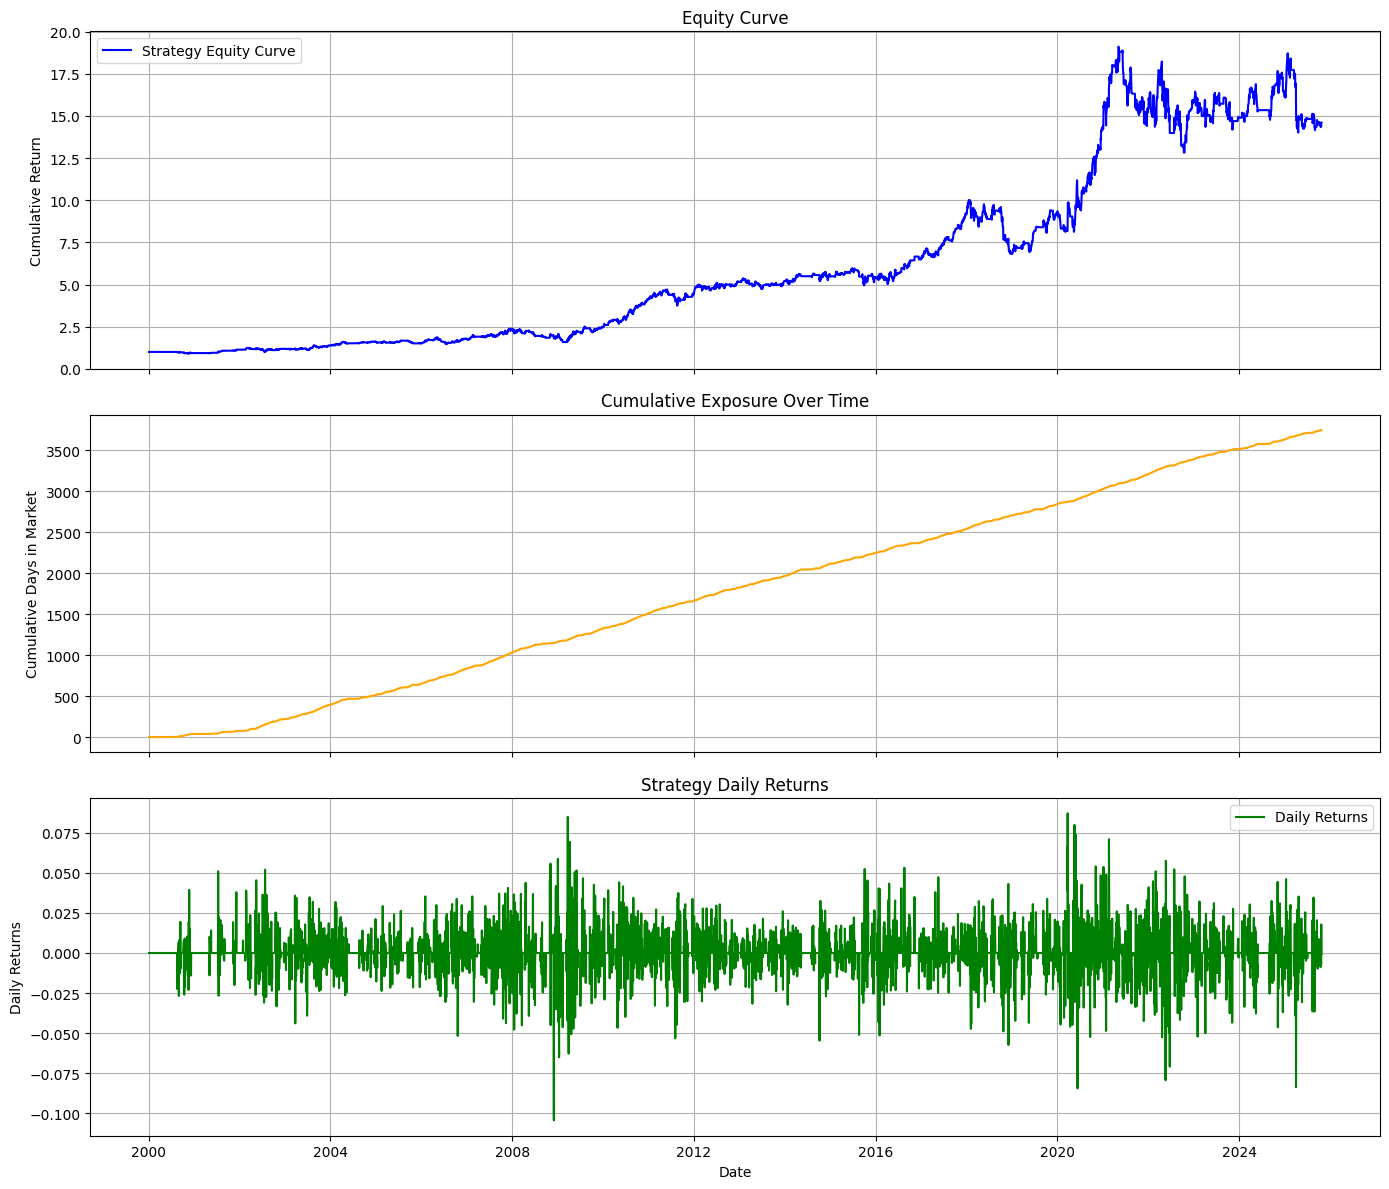

In [12]:
# Plotting my results
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot for equity curve
axs[0].plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='blue')
axs[0].set_ylabel('Cumulative Return')
axs[0].set_title('Equity Curve')
axs[0].grid(True)
axs[0].legend()

# Plot for cumulative exposure over time.. I found this to be more intuitive than a binary plot
cumulative_exposure = exposure.cumsum()
axs[1].plot(cumulative_exposure.index, cumulative_exposure, color='orange')
axs[1].set_ylabel('Cumulative Days in Market')
axs[1].set_title('Cumulative Exposure Over Time')
axs[1].grid(True)

# Plotting daily returns
axs[2].plot(strategy_returns.index, strategy_returns, label='Daily Returns', color='green')
axs[2].set_ylabel('Daily Returns')
axs[2].set_title('Strategy Daily Returns')
axs[2].set_xlabel('Date')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [13]:
# Calculating daily returns for benchmark tickers. Filling missing data with 0
benchmark_returns = data[benchmark_tickers].pct_change(fill_method=None).fillna(0)

In [14]:
# Calculating cumulative returns
strategy_cum = (1 + strategy_returns).cumprod()
benchmarks_cum = (1 + benchmark_returns).cumprod()

In [15]:
# Calculating Sharpe ratios.. these are annualized, assuming 252 trading days
def sharpe_ratio(r):
    return (r.mean() / r.std()) * np.sqrt(252)
    
strategy_sharpe = sharpe_ratio(strategy_returns)
benchmarks_sharpe = benchmark_returns.apply(sharpe_ratio)

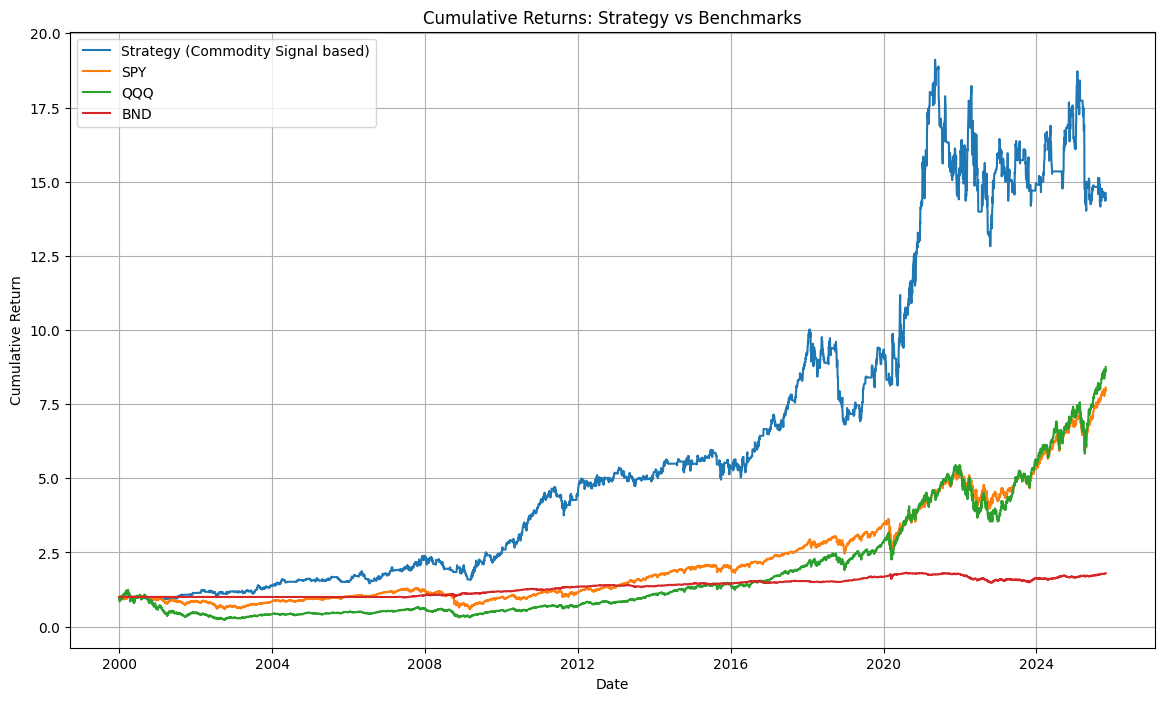

In [16]:
# Plotting cumulative returns
plt.figure(figsize=(14, 8))
plt.plot(strategy_cum, label='Strategy (Commodity Signal based)')
for bench in benchmarks_cum.columns:
    plt.plot(benchmarks_cum[bench], label=bench)
plt.title('Cumulative Returns: Strategy vs Benchmarks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Printing Sharpe ratios
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.3f}")
for bench in benchmarks_sharpe.index:
    print(f"{bench} Sharpe Ratio: {benchmarks_sharpe[bench]:.3f}")

Strategy Sharpe Ratio: 0.644
SPY Sharpe Ratio: 0.514
QQQ Sharpe Ratio: 0.447
BND Sharpe Ratio: 0.533
